# Group Project - Smoking Data Integration
Jackson Viscomi

In [18]:
import pandas as pd

## Import Cleaned Facets Dataset 

In [19]:
path = "C:/Users/jcviscom/OneDrive - Intermountain Healthcare/Documents/U Biomedical Informatics/BMI 6016/Group Project/MASTER_FACETS_DATA_AllColumns.csv"
facets = pd.read_csv(path)
#pull most recent data (2018)
facets = facets[facets['Year'] == 2018]

## Import Smoking Rates Dataset  
Source data on county level, evenly spread throughout each corresponding FIPS code.

In [20]:
path2 = "C:/Users/jcviscom/OneDrive - Intermountain Healthcare/Documents/U Biomedical Informatics/BMI 6016/Group Project/Tract to ZIP, County + Smoking Rates.csv"
smoking_df = pd.read_csv(path2)

## Join Smoking Rates to FACETS dataset

In [21]:
#renaming the column to match FACETS before the join 
smoking_df.rename(columns={'tract': 'FIPS'}, inplace = True)

In [22]:
#performing a left join on the FACETS data
FACETS_Joined = pd.merge(facets, smoking_df[["FIPS","Smoking Rates (county)","County Name"]], how="left", on=["FIPS"])

In [23]:
#narrowing down the columns
FACETS_Joined_Smoking = FACETS_Joined[["FIPS","County Name","Total_Population", "Smoking Rates (county)", "Tob_Retailer_Per_1000"]]

In [24]:
#changing data type for smoking rates
FACETS_Joined_Smoking['Smoking Rates (county)'] = FACETS_Joined_Smoking['Smoking Rates (county)'].str[:-1].astype(float)/100

<ipython-input-24-b04dc155f3be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FACETS_Joined_Smoking['Smoking Rates (county)'] = FACETS_Joined_Smoking['Smoking Rates (county)'].str[:-1].astype(float)/100


## Data Quality Assesment

To first get a general idea of the data I threw in a describe() statement to get some summary statistics

In [25]:
FACETS_Joined_Smoking.describe()

,FIPS,Total_Population,Smoking Rates (county),Tob_Retailer_Per_1000
count,2.167000e+03,2167.000000,2140.000000,2167.000000
mean,3.605476e+10,3904.919705,0.117631,1.215505
std,2.594875e+07,2250.634819,0.012981,6.864886
min,3.600500e+10,0.000000,0.096000,0.000000
25%,3.604703e+10,2368.000000,0.109000,0.000000
50%,3.604712e+10,3560.000000,0.114000,1.000000
75%,3.608103e+10,4966.000000,0.132000,1.000000
max,3.608599e+10,29256.000000,0.132000,205.000000


In [26]:
FACETS_Joined_Smoking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FIPS                    2167 non-null   int64  
 1   County Name             2140 non-null   object 
 2   Total_Population        2167 non-null   int64  
 3   Smoking Rates (county)  2140 non-null   float64
 4   Tob_Retailer_Per_1000   2167 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 101.6+ KB


What stuck out to me was the following: 
- Different non-null counts (non-perfect join)
- A FIPS location with 205 tobacco retailers per 1000 residents
- FIPS location(s) with 0 residents

### Filling NaNs

First area of improvement was sourcing missing country names. Wayne had found another FIPS to County crosswalk from 2020 that could help fill in the missing pieces

In [27]:
FACETS_Joined_Smoking[FACETS_Joined_Smoking['County Name'].isnull()].sum()

FIPS                      973997995924
County Name                          0
Total_Population                 95542
Smoking Rates (county)             0.0
Tob_Retailer_Per_1000              0.0
dtype: object

I brought in an addition source the Wayne found to map more FIPS codes to boroughs and get neighborhood-level data.

In [28]:
path3 = "C:/Users/jcviscom/OneDrive - Intermountain Healthcare/Documents/U Biomedical Informatics/BMI 6016/Group Project/BoroughSource2.csv"
crosswalk2 = pd.read_csv(path3)
#renaming joining key for merge statement
crosswalk2.rename(columns={'GEOID': 'FIPS'}, inplace = True)

In [29]:
FACETS_Joined_2 = pd.merge(FACETS_Joined_Smoking, crosswalk2[["FIPS","BoroName","NTAName"]], how="left", on=["FIPS"])

In [30]:
FACETS_Joined_2['County Merged'] = FACETS_Joined_2['County Name'].fillna(FACETS_Joined_2['BoroName'])

In [31]:
FACETS_Joined_2[FACETS_Joined_2['County Merged'].isnull()].sum()

FIPS                      72162201803
County Name                         0
Total_Population                20295
Smoking Rates (county)            0.0
Tob_Retailer_Per_1000             0.0
BoroName                            0
NTAName                             0
County Merged                       0
dtype: object

In [32]:
FACETS_Joined_2[FACETS_Joined_2['County Merged'].isnull()]

,FIPS,County Name,Total_Population,Smoking Rates (county),Tob_Retailer_Per_1000,BoroName,NTAName,County Merged
1956,36081100802,NaN,9319,NaN,0.0,NaN,NaN,NaN
1957,36081101001,NaN,10976,NaN,0.0,NaN,NaN,NaN


Not perfect, put accounting for 75,647 extra lives. I also found out that the first 5 digits of the FIPs can tell the county:  

Bronx     36005  
Kings     36047  
New York  36061  
Queens    36081  
Richmond  36085  

given that, these last two FIPS belong to Queens

In [33]:
FACETS_Joined_2['County Merged'].fillna('Queens', inplace = True)

In [34]:
#replacing County Merged with original County Name
FACETS_Joined_2.drop(columns = ['County Name'], inplace=True)

No more FIPs with null county names.

## Unpopulated FIPS codes

Since our project is public health focused, there is no reason to include SDOH metrics from areas without residents.

In [35]:
FACETS_Joined_2 = FACETS_Joined_2[FACETS_Joined_2['Total_Population']!=0]

## Addressing Outliers

Given that our smoking rates were given on a county level, the only metric which could contain outliers was the Tobacoo Retialers Per 1,000.  

An article from the NIH cited the range of Tobacco Retailers Per 100 as 0-17.5. This corresonded to all values within the 99.3 percentile of values.  

Article (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8523582/)

In [36]:
import numpy as np

In [37]:
FACETS_Joined_2['Tob_Retailer_Per_1000'].quantile(np.linspace(.05, 1, 19, 0))

0.05    0.0
0.10    0.0
0.15    0.0
0.20    0.0
0.25    0.0
0.30    0.0
0.35    0.0
0.40    0.0
0.45    0.0
0.50    1.0
0.55    1.0
0.60    1.0
0.65    1.0
0.70    1.0
0.75    1.0
0.80    2.0
0.85    2.0
0.90    2.0
0.95    3.0
Name: Tob_Retailer_Per_1000, dtype: float64

Narrowing down, I saw that our researched outliers were falling within the 99.7th percentile of our dataset. This is reassuring as it doesn't contradict the NIH article.

In [38]:
FACETS_Joined_2['Tob_Retailer_Per_1000'].quantile(np.linspace(.996, .998, 2, 0))

0.996    11.492
0.997    16.000
Name: Tob_Retailer_Per_1000, dtype: float64

In [39]:
FACETS_Joined_2[FACETS_Joined_2['Tob_Retailer_Per_1000'] > FACETS_Joined_2['Tob_Retailer_Per_1000'].quantile(.997)]

,FIPS,Total_Population,Smoking Rates (county),Tob_Retailer_Per_1000,BoroName,NTAName,County Merged
1193,36061009400,44,0.096,205.0,New York,Midtown-Times Square,New York
1195,36061009600,119,0.096,76.0,New York,Midtown-Times Square,New York
1201,36061010200,180,0.096,83.0,New York,Midtown-Times Square,New York
1207,36061010900,147,0.096,102.0,New York,Midtown-Times Square,New York
1213,36061011300,120,0.096,117.0,New York,Midtown-Times Square,New York
2143,36085022800,41,0.128,146.0,NaN,NaN,Richmond


For imputing these values, I will first use the NTA average and then the county average for those with a null NTA value:

First, calcuating non-null county averages and merging in the averages to the larger dataset

In [40]:
FACETS_Smoking_NTA_Avg = FACETS_Joined_2[['NTAName','Tob_Retailer_Per_1000']].groupby('NTAName').median()
FACETS_Smoking_NTA_Avg.reset_index(inplace = True)

In [41]:
FACETS_Joined_2 = pd.merge(FACETS_Joined_2, FACETS_Smoking_NTA_Avg, how="left", on=['NTAName'])

In [42]:
FACETS_Joined_2.rename(columns = {'Tob_Retailer_Per_1000_y':'Tob_Retailer_Per_1000_NTA_Avg','Tob_Retailer_Per_1000_x':'Tob_Retailer_Per_1000'}, inplace = True)

Repeating this same process for County-level averages. 

In [44]:
FACETS_Smoking_County_Avg = FACETS_Joined_2[['County Merged','Tob_Retailer_Per_1000']].groupby('County Merged').median()
FACETS_Smoking_County_Avg.reset_index(inplace = True)

In [45]:
FACETS_Joined_2 = pd.merge(FACETS_Joined_2, FACETS_Smoking_County_Avg, how="left", on=['County Merged'])

In [46]:
FACETS_Joined_2.rename(columns = {'Tob_Retailer_Per_1000_x':'Tob_Retailer_Per_1000','Tob_Retailer_Per_1000_y':'Tob_Retailer_Per_1000_County_Avg'}, inplace = True)

1) Filling null NTA averges with county-level avergaes  
2) Creating a logic that will first check if the the value is greater than 16, if true, will replace it with the NTA/County level average

In [47]:
FACETS_Joined_2['Tob_Retailer_Per_1000_NTA_Avg'].fillna(FACETS_Joined_2['Tob_Retailer_Per_1000_County_Avg'], inplace = True)
FACETS_Joined_2['Tob_Retailer_Per_1000_Fix'] = np.where(FACETS_Joined_2['Tob_Retailer_Per_1000']>=16, FACETS_Joined_2['Tob_Retailer_Per_1000_NTA_Avg'],FACETS_Joined_2['Tob_Retailer_Per_1000'])

Seeing it in action:

In [49]:
FACETS_Joined_2.drop(columns = ['Tob_Retailer_Per_1000_NTA_Avg','Tob_Retailer_Per_1000_County_Avg'], inplace=True)

In [50]:
FACETS_Joined_2[FACETS_Joined_2['Tob_Retailer_Per_1000']>=16]

,FIPS,Total_Population,Smoking Rates (county),Tob_Retailer_Per_1000,BoroName,NTAName,County Merged,Tob_Retailer_Per_1000_Fix
319,36005043500,62,0.114,16.0,NaN,NaN,Bronx,1.0
358,36047003700,1214,0.132,16.0,Kings,Downtown Brooklyn-DUMBO-Boerum Hill,Kings,1.5
1177,36061009400,44,0.096,205.0,New York,Midtown-Times Square,New York,8.5
1179,36061009600,119,0.096,76.0,New York,Midtown-Times Square,New York,8.5
1185,36061010200,180,0.096,83.0,New York,Midtown-Times Square,New York,8.5
1191,36061010900,147,0.096,102.0,New York,Midtown-Times Square,New York,8.5
1197,36061011300,120,0.096,117.0,New York,Midtown-Times Square,New York,8.5
2105,36085022800,41,0.128,146.0,NaN,NaN,Richmond,1.0


In [51]:
FACETS_Joined_2.drop(columns = ['Tob_Retailer_Per_1000'], inplace=True)
FACETS_Joined_2.rename(columns = {'Tob_Retailer_Per_1000_Fix':'Tob_Retailer_Per_1000'}, inplace=True)

In [52]:
FACETS_Joined_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2128 entries, 0 to 2127
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FIPS                    2128 non-null   int64  
 1   Total_Population        2128 non-null   int64  
 2   Smoking Rates (county)  2110 non-null   float64
 3   BoroName                1998 non-null   object 
 4   NTAName                 1998 non-null   object 
 5   County Merged           2128 non-null   object 
 6   Tob_Retailer_Per_1000   2128 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 133.0+ KB


Looking much better. I chose not to fill the rest of the Smoking rates for this exercise since the data was gatered at a county level and will be shown at a county level.

# Plotting Cleaned Data

In [356]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [357]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

Pre-processing the heat map for visualizations.

In [358]:
boundaries = gpd.read_file('C:/Users/jcviscom/Downloads/Borough Boundaries/geo_export_4bf61b73-3f85-41ef-9ccc-c01719c9f685.shp')
boundaries = boundaries.astype({'boro_code':'int64'})
boundaries.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5,Staten Island,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1,Manhattan,6.365208e+08,357564.316391,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3,Brooklyn,1.934143e+09,728197.541089,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4,Queens,3.041419e+09,888199.731579,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [359]:
FACETS_Joined_2.groupby('BoroName').count()

,FIPS,Total_Population,Smoking Rates (county),NTAName,County Merged,Tob_Retailer_Per_1000
BoroName,,,,,,
Bronx,320,320,319,320,320,320
Kings,712,712,712,712,712,712
New York,267,267,267,267,267,267
Queens,605,605,590,605,605,605
Richmond,94,94,94,94,94,94


In [360]:
FACETS_Joined_2['BoroName'].replace({'New York':'Manhattan'}, inplace=True)
FACETS_Joined_2['BoroName'].replace({'Richmond':'Staten Island'}, inplace=True)
FACETS_Joined_2['BoroName'].replace({'Kings':'Brooklyn'}, inplace=True)
boundaries.rename(columns={'boro_name': 'BoroName'}, inplace = True)

FACETS_Joined_Geo = pd.merge(FACETS_Joined_2, boundaries, how="left", on=['BoroName'])
FACETS_Joined_Geo

,FIPS,Total_Population,Smoking Rates (county),BoroName,NTAName,County Merged,Tob_Retailer_Per_1000,boro_code,shape_area,shape_leng,geometry
0,36005000100,7503,NaN,Bronx,Rikers Island,Bronx,0.0,2.0,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,36005000200,5251,0.114,Bronx,Soundview-Clason Point,Bronx,1.0,2.0,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,36005000400,5980,0.114,Bronx,Soundview-Clason Point,Bronx,1.0,2.0,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
3,36005001600,6056,0.114,Bronx,Soundview-Clason Point,Bronx,1.0,2.0,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
4,36005001900,2682,0.114,NaN,NaN,Bronx,1.0,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...
2123,36085030301,4897,0.128,Staten Island,Mariner's Harbor-Arlington-Graniteville,Richmond,1.0,5.0,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2124,36085030302,6142,0.128,Staten Island,Mariner's Harbor-Arlington-Graniteville,Richmond,2.0,5.0,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2125,36085031901,2564,0.128,Staten Island,Mariner's Harbor-Arlington-Graniteville,Richmond,0.0,5.0,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2126,36085031902,4480,0.128,Staten Island,Mariner's Harbor-Arlington-Graniteville,Richmond,1.0,5.0,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."


In [361]:
from geopandas import GeoDataFrame
import matplotlib.ticker as mtick

In [363]:
from geopandas import GeoDataFrame

FACETS_Joined_Geo = GeoDataFrame(FACETS_Joined_Geo)

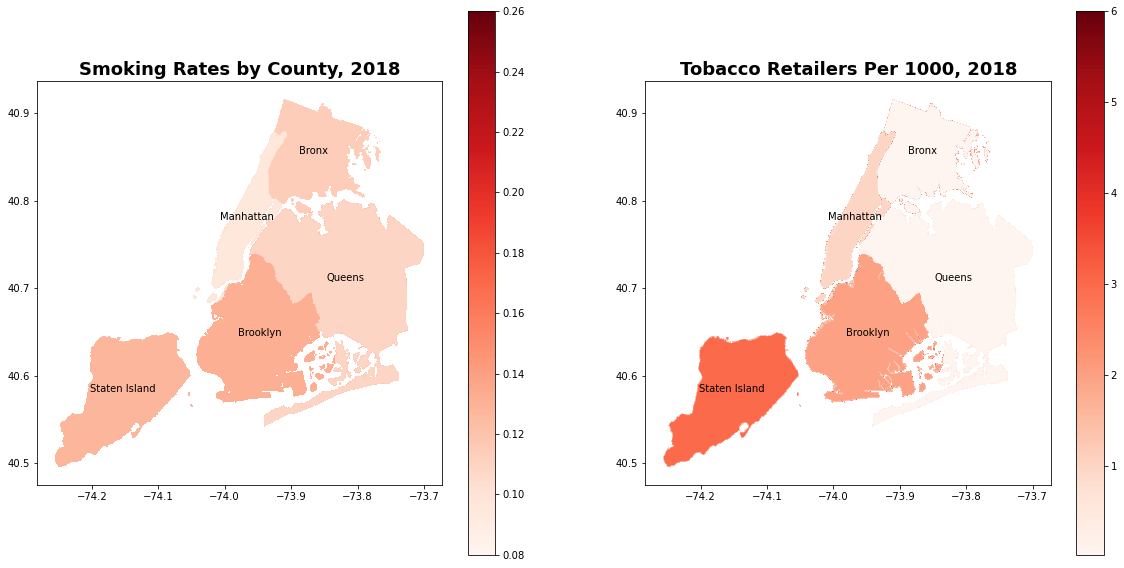

In [364]:
cmap1 = 'Reds'
norm1 = plt.Normalize(vmin=.08, vmax=.26)

cmap2 = 'Reds'
norm2 = plt.Normalize(vmin= .03, vmax= 6)

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))

FACETS_Joined_Geo.plot(column='Smoking Rates (county)', cmap=cmap1, norm=norm1, ax=axs[0], legend=True)
axs[0].set_title("Smoking Rates by County, 2018", fontsize=18, fontweight='bold')
for idx, row in boundaries.iterrows():
    axs[0].annotate(text=row['BoroName'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10)

FACETS_Joined_Geo.plot(column='Tob_Retailer_Per_1000', cmap=cmap2, norm=norm2, ax=axs[1], legend=True)
axs[1].set_title("Tobacco Retailers Per 1000, 2018", fontsize=18, fontweight='bold')
for idx, row in boundaries.iterrows():
    axs[1].annotate(text=row['BoroName'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10)

plt.show()

Below is the code I used for the COVID cases per 100K visualization: 

# Covid Cases Per 100K (2020)

In [25]:
data_covid_2020 = pd.read_csv('C:/Users/jcviscom/Downloads/data-by-day.csv')
data_covid_2020['date_of_interest'] = pd.to_datetime(data_covid_2020['date_of_interest'])
count_qns_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'QN_CASE_COUNT'].sum()
print("\n Queens total count for 2020: ", count_qns_2020)
count_brooklyn_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'BK_CASE_COUNT'].sum()
print("\n Brooklyn total count for 2020: ", count_brooklyn_2020)
count_bronx_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'BX_CASE_COUNT'].sum()
print("\n Bronx total count for 2020: ", count_bronx_2020)
count_mhtn_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'MN_CASE_COUNT'].sum()
print("\n Manhattan total count for 2020: ", count_mhtn_2020)
count_stn_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'SI_CASE_COUNT'].sum()
print("\n Staten Island total count for 2020: ", count_stn_2020)
all_counts = [[count_qns_2020,4], [count_brooklyn_2020,3],[count_bronx_2020,2],[count_mhtn_2020,1],[count_stn_2020,5]]


 Queens total count for 2020:  117063

 Brooklyn total count for 2020:  115636

 Bronx total count for 2020:  80527

 Manhattan total count for 2020:  55685

 Staten Island total count for 2020:  32627


In [20]:
PopBorough = pd.read_csv('C:/Users/jcviscom/Downloads/Population By Borough.csv')
PopBorough.rename(columns = {'Borough':'boro_name'},inplace=True)

In [24]:
PopBorough['Population'].astype(str).astype(int)
PopBorough

,boro_name,Population
0,Bronx,1472654
1,Brooklyn,2736074
2,Manhattan,1694251
3,Queens,2405464
4,Staten Island,495747


In [27]:
data_counts = pd.DataFrame(all_counts, columns=['Number', 'GeoID'])
#print(data_counts)
merged_data_counts = pd.merge(boundaries, data_counts, left_on='boro_code', right_on='GeoID', how='right')
merged_data_counts = pd.merge(merged_data_counts, PopBorough, how="left", on=["boro_name"] )
merged_data_counts['Cases Per 100K'] = (merged_data_counts['Number']/merged_data_counts['Population'])*100000
merged_data_counts
#print(type(merged_data_counts['Number']))

,boro_code,boro_name,shape_area,shape_leng,geometry,Number,GeoID,Population,Cases Per 100K
0,4,Queens,3.041419e+09,888199.731579,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...",117063,4,2405464,4866.545498
1,3,Brooklyn,1.934143e+09,728197.541089,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...",115636,3,2736074,4226.347679
2,2,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",80527,2,1472654,5468.154774
3,1,Manhattan,6.365208e+08,357564.316391,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",55685,1,1694251,3286.703092
4,5,Staten Island,1.623621e+09,325917.353702,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",32627,5,495747,6581.381229


In [110]:
# merged_data_counts['Number'] = merged_data_counts['Number'].str.replace(',', '').astype(float)

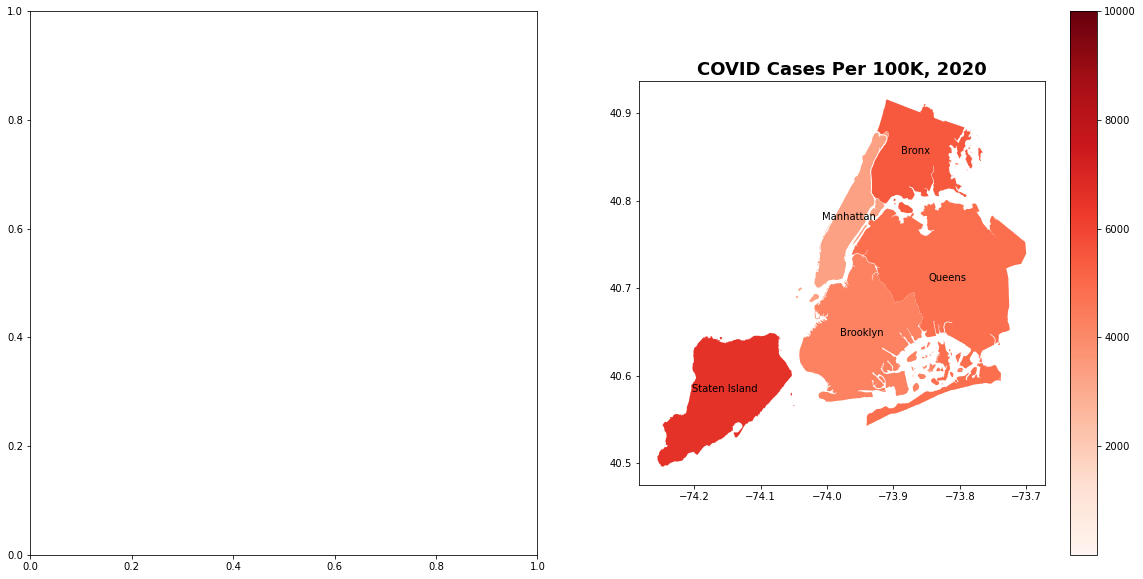

In [30]:
#cmap1 = 'Reds'
#norm1 = plt.Normalize(vmin=merged_obese_2020['Number'].min(), vmax=merged_obese_2020['Number'].max())

cmap2 = 'Reds'
norm2 = plt.Normalize(vmin=0.1, vmax=10000)

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))

#merged_obese_2020.plot(column='Number', cmap=cmap1, norm=norm1, ax=axs[0], legend=True)
#axs[0].set_title('Obesity count in Adults for the year 2020', fontsize=18, fontweight='bold')
#for idx, row in boundaries.iterrows():
#    axs[0].annotate(text=row['boro_name'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10)

merged_data_counts.plot(column='Cases Per 100K', cmap=cmap2, norm=norm2, ax=axs[1], legend=True)
axs[1].set_title('COVID Cases Per 100K, 2020', fontsize=18, fontweight='bold')
for idx, row in boundaries.iterrows():
    axs[1].annotate(text=row['boro_name'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10)

plt.show()

In [ ]:
# Covid Cases Per 100K (2020)

data_covid_2020 = pd.read_csv('C:/Users/jcviscom/Downloads/data-by-day.csv')
data_covid_2020['date_of_interest'] = pd.to_datetime(data_covid_2020['date_of_interest'])
count_qns_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'QN_CASE_COUNT'].sum()
print("\n Queens total count for 2020: ", count_qns_2020)
count_brooklyn_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'BK_CASE_COUNT'].sum()
print("\n Brooklyn total count for 2020: ", count_brooklyn_2020)
count_bronx_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'BX_CASE_COUNT'].sum()
print("\n Bronx total count for 2020: ", count_bronx_2020)
count_mhtn_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'MN_CASE_COUNT'].sum()
print("\n Manhattan total count for 2020: ", count_mhtn_2020)
count_stn_2020 = data_covid_2020.loc[data_covid_2020['date_of_interest'].dt.year == 2020, 'SI_CASE_COUNT'].sum()
print("\n Staten Island total count for 2020: ", count_stn_2020)
all_counts = [[count_qns_2020,4], [count_brooklyn_2020,3],[count_bronx_2020,2],[count_mhtn_2020,1],[count_stn_2020,5]]

PopBorough = pd.read_csv('C:/Users/jcviscom/Downloads/Population By Borough.csv')
PopBorough.rename(columns = {'Borough':'boro_name'},inplace=True)

PopBorough['Population'].astype(str).astype(int)
PopBorough

data_counts = pd.DataFrame(all_counts, columns=['Number', 'GeoID'])
#print(data_counts)
merged_data_counts = pd.merge(boundaries, data_counts, left_on='boro_code', right_on='GeoID', how='right')
merged_data_counts = pd.merge(merged_data_counts, PopBorough, how="left", on=["boro_name"] )
merged_data_counts['Cases Per 100K'] = (merged_data_counts['Number']/merged_data_counts['Population'])*100000
merged_data_counts
#print(type(merged_data_counts['Number']))

# merged_data_counts['Number'] = merged_data_counts['Number'].str.replace(',', '').astype(float)

#cmap1 = 'Reds'
#norm1 = plt.Normalize(vmin=merged_obese_2020['Number'].min(), vmax=merged_obese_2020['Number'].max())

cmap2 = 'Reds'
norm2 = plt.Normalize(vmin=0.1, vmax=10000)

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))

#merged_obese_2020.plot(column='Number', cmap=cmap1, norm=norm1, ax=axs[0], legend=True)
#axs[0].set_title('Obesity count in Adults for the year 2020', fontsize=18, fontweight='bold')
#for idx, row in boundaries.iterrows():
#    axs[0].annotate(text=row['boro_name'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10)

merged_data_counts.plot(column='Cases Per 100K', cmap=cmap2, norm=norm2, ax=axs[1], legend=True)
axs[1].set_title('COVID Cases Per 100K, 2020', fontsize=18, fontweight='bold')
for idx, row in boundaries.iterrows():
    axs[1].annotate(text=row['boro_name'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=10)

plt.show()